In [1]:
import pandas as pd
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sophialin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
all_posts = pd.read_csv("redditposts_full.csv")

In [3]:
all_posts = all_posts.drop(columns = "Unnamed: 0")

In [4]:
## Sentiment Analysis on text data
sia = SentimentIntensityAnalyzer()
all_posts['sentiment'] = all_posts['Text'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

In [115]:
all_posts["Total Comments"] = pd.to_numeric(all_posts["Total Comments"], errors='coerce')

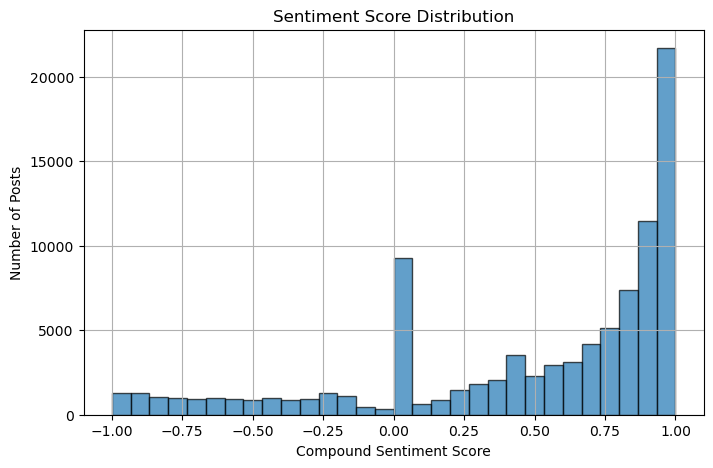

In [116]:
import matplotlib.pyplot as plt
## distribution of sentiment
plt.figure(figsize=(8, 5))
plt.hist(all_posts['sentiment'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Sentiment Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()


In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
## Perform bert embedding which convert tects in to numeric vectors

texts = all_posts['Text'].fillna('').tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')  
embeddings = model.encode(texts, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating BERT embeddings...


Batches:   0%|          | 0/2883 [00:00<?, ?it/s]

Applying PCA to reduce dimensions...
Explained variance ratio: [0.07196042 0.03939711 0.03023865 0.02604487 0.02597615 0.02027848
 0.01998129 0.01730494 0.0162421  0.01489396]
Total variance retained: 0.28231795943406474


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


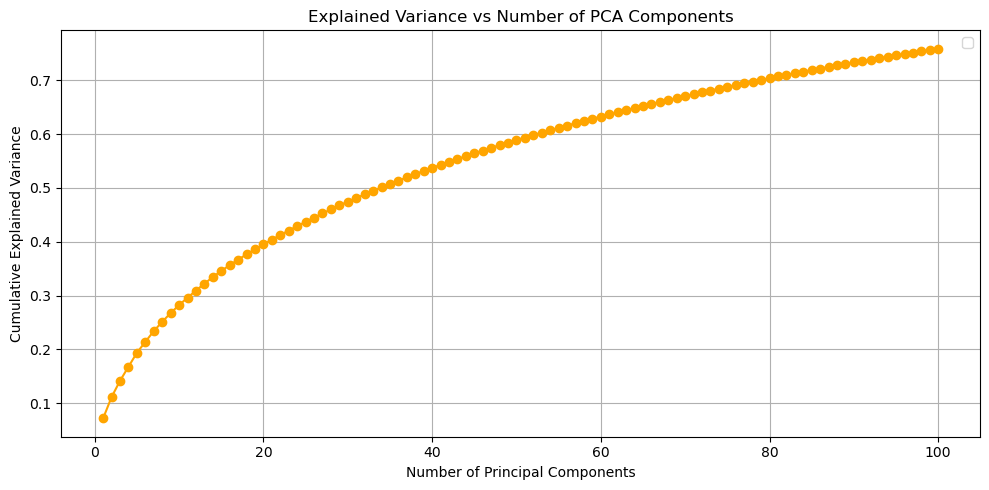

In [10]:
## Tried PCA 
pca = PCA(n_components=100)
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
## PCA not so useful, so just keep all for clustering. 

/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

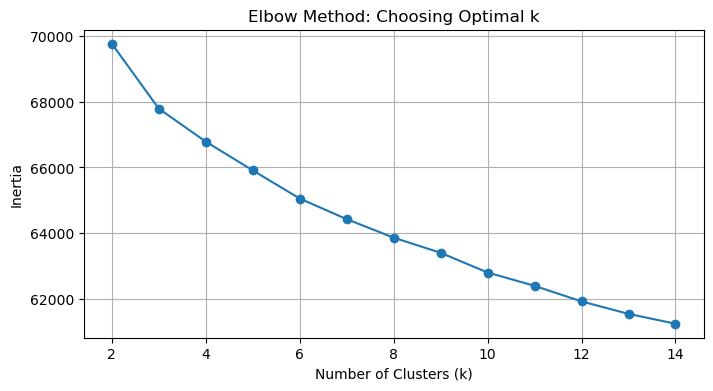

In [12]:
from sklearn.cluster import KMeans
## apply k-means clustering to cluster the posts
## choose the optimal number of clusters
inertias = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)  
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method: Choosing Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


Based on the plot, there is a steep drop between k = 2 and k = 3, and after that the inertia decreases at a decreasing rate. So we should choose k = 3. 

In [117]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings)
all_posts['cluster'] = clusters

/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [118]:
all_posts = all_posts.drop(columns=[col for col in all_posts.columns if "embedding" in col])

In [119]:
all_posts['cluster'].value_counts().sort_index()


cluster
0    40779
1    31402
2    20057
Name: count, dtype: int64

/Users/sophialin/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


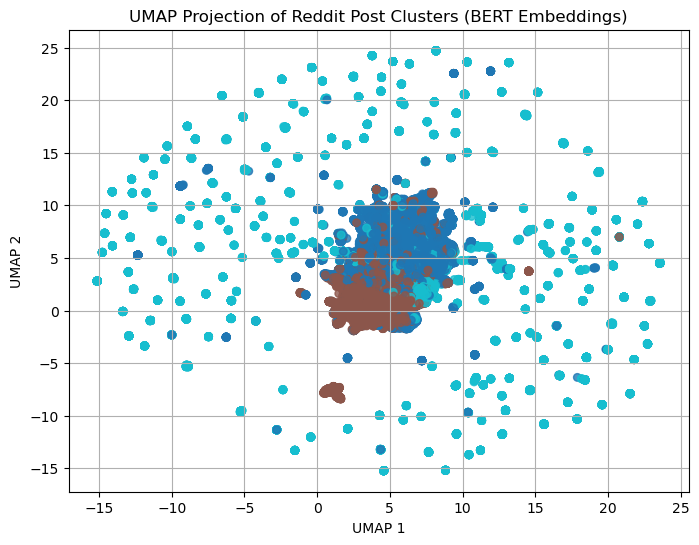

In [29]:
## Visualize the clusters
import umap
import matplotlib.pyplot as plt
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_model.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
            c=all_posts['cluster'], cmap='tab10', s=30, alpha=0.8)
plt.title("UMAP Projection of Reddit Post Clusters (BERT Embeddings)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()



In [120]:
## Look at some posts from each cluster
## I want to figure out what does each cluster talk about but don't know how
for c in sorted(all_posts['cluster'].unique()):
    print(f"\nCluster {c} examples:")
    print(all_posts[all_posts['cluster'] == c]['Text'].head(3).tolist())



Cluster 0 examples:
["World's largest free trade agreement, RCEP, kicks in [As per the title](https://www.straitstimes.com/business/economy/worlds-largest-free-trade-agreement-rcep-kicks-in-cutting-tariffs-for-92-of-goods-traded-among-parties).\n\nKey points:\n\n* The agreement cuts tariffs for most (92%) of goods traded\n* It includes Japan, China, Singapore, Thailand, Vietnam, Cambodia, Brunei, Laos, Australia, and New Zealand\n* South Korea will join as of Feb 1\n* The Philippines is expected to ratify soon\n* The agreement also means businesses can benefit from preferential market access for goods e.g. mineral fuels, plastics, other chemical products, miscellaneous food preparations and beverages\n\nThoughts on how this will affect stocks or other investments? Will this help companies like Sea Limited (with business in much of SE Asia) do business easier or cheaper? Will it help Japanese companies grow their presence in SE Asia?", "Doubt regarding Leveraged ETF calculation Suppose

In [121]:
import numpy as np
df = all_posts.copy()
df['Date'] = pd.to_datetime(df['Date']).dt.date
eps = 1e-6

##Use weighted sentiment as posts with higher score havs large influence
df['weighted_sentiment'] = df['Score'] * df['sentiment']
## aggregate feature for each day

daily_features = df.groupby('Date').agg(
    n_posts=('Text', 'count'),
    total_score=('Score', 'sum'),
    avg_score=('Score', 'mean'),
    total_comments=('Total Comments', 'sum'),
    avg_comments=('Total Comments', 'mean'),
    avg_upvote_ratio=('Upvote Ratio', 'mean'),
    std_upvote_ratio=('Upvote Ratio', 'std'),
    weighted_sentiment_sum=('weighted_sentiment', 'sum'),
    weighted_sentiment_denom=('Score', 'sum')
)

daily_features['weighted_sentiment'] = (
    daily_features['weighted_sentiment_sum'] /
    (daily_features['weighted_sentiment_denom'] + eps)
)

daily_features.drop(columns=['weighted_sentiment_sum', 'weighted_sentiment_denom'], inplace=True)


In [123]:
daily_features

,n_posts,total_score,avg_score,total_comments,avg_comments,avg_upvote_ratio,std_upvote_ratio,weighted_sentiment
Date,,,,,,,,
2022-01-01,45,6826.0,151.688889,5276.0,117.244444,0.784000,0.142181,0.152549
2022-01-02,62,20694.0,333.774194,7896.0,127.354839,0.726452,0.201642,0.578712
2022-01-03,80,8157.0,101.962500,4635.0,57.937500,0.748875,0.183772,0.714598
2022-01-04,107,6301.0,58.887850,6044.0,56.485981,0.754019,0.187706,0.238031
2022-01-05,103,6813.0,66.145631,6585.0,63.932039,0.772233,0.196284,0.764551
...,...,...,...,...,...,...,...,...
2024-12-27,185,2436.0,13.167568,3718.0,20.097297,0.755730,0.248061,0.541830
2024-12-28,117,1456.0,12.444444,2377.0,20.316239,0.724359,0.254217,0.474730
2024-12-29,113,1377.0,12.185841,2177.0,19.265487,0.701504,0.247344,0.482219


In [124]:
all_posts['Date'] = pd.to_datetime(all_posts['Date']).dt.date
eps = 1e-6
cluster_counts = all_posts.groupby(['Date', 'cluster']).size().unstack(fill_value=0)
cluster_counts.columns = [f"cluster_{col}_count" for col in cluster_counts.columns]
if 'sentiment' in all_posts.columns and 'Score' in all_posts.columns:
    all_posts['weighted_sentiment'] = all_posts['Score'] * all_posts['sentiment']
    
    weighted = all_posts.groupby(['Date', 'cluster']).agg(
        weighted_sum=('weighted_sentiment', 'sum'),
        score_sum=('Score', 'sum')
    ).reset_index()
    
    weighted['weighted_sentiment'] = weighted['weighted_sum'] / (weighted['score_sum'] + eps)
    
    weighted_sentiment = weighted.pivot(index='Date', columns='cluster', values='weighted_sentiment')
    weighted_sentiment.columns = [f"cluster_{col}_weighted_sentiment" for col in weighted_sentiment.columns]
    

    features = pd.concat([cluster_counts, weighted_sentiment], axis=1).fillna(0)
else:
    features = cluster_counts

features = features.sort_index().asfreq('D', fill_value=0)


In [125]:
features

,cluster_0_count,cluster_1_count,cluster_2_count,cluster_0_weighted_sentiment,cluster_1_weighted_sentiment,cluster_2_weighted_sentiment
Date,,,,,,
2022-01-01,25,15,5,-0.099146,0.817283,0.587754
2022-01-02,39,18,5,0.341425,0.738773,0.189691
2022-01-03,37,31,12,0.924933,-0.043935,0.660637
2022-01-04,60,39,8,0.301829,0.137573,-0.228860
2022-01-05,69,26,8,0.794268,0.588157,0.812369
...,...,...,...,...,...,...
2024-12-27,61,84,40,0.572747,0.502634,0.459468
2024-12-28,33,65,19,0.412829,0.567195,0.493900
2024-12-29,31,67,15,0.243238,0.615036,0.585525


In [126]:
all_features = daily_features.merge(features, left_index=True, right_index=True, how='left')

In [127]:
all_features.to_csv("all_features.csv")

In [128]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'TSLA', 'META', 'AMZN', 'NVDA']
prices = yf.download(tickers, start="2022-01-01", end="2024-12-31")['Close']
returns = prices.pct_change().shift(-1)
returns.columns = [f"{ticker}_return" for ticker in returns.columns]
returns.index = returns.index.date

[*********************100%***********************]  5 of 5 completed


In [84]:
merged = pd.merge(all_features, returns, left_index=True, right_index=True, how='inner')


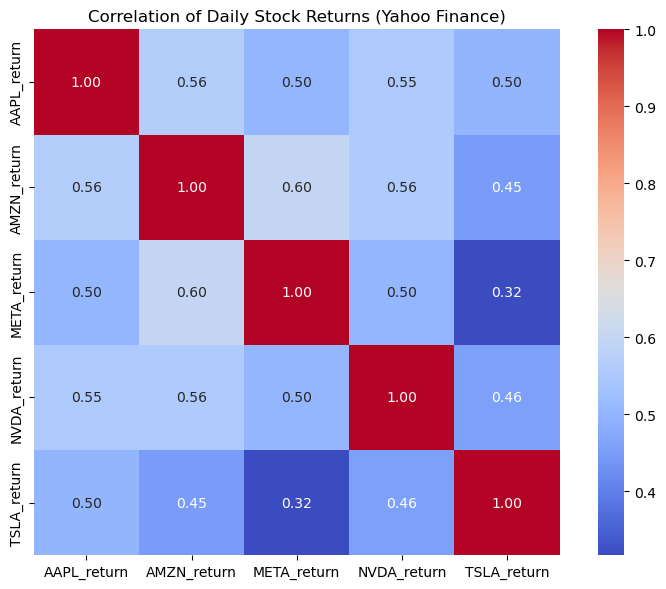

In [85]:
import seaborn as sns
correlation_matrix = returns.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation of Daily Stock Returns (Yahoo Finance)")
plt.tight_layout()
plt.show()

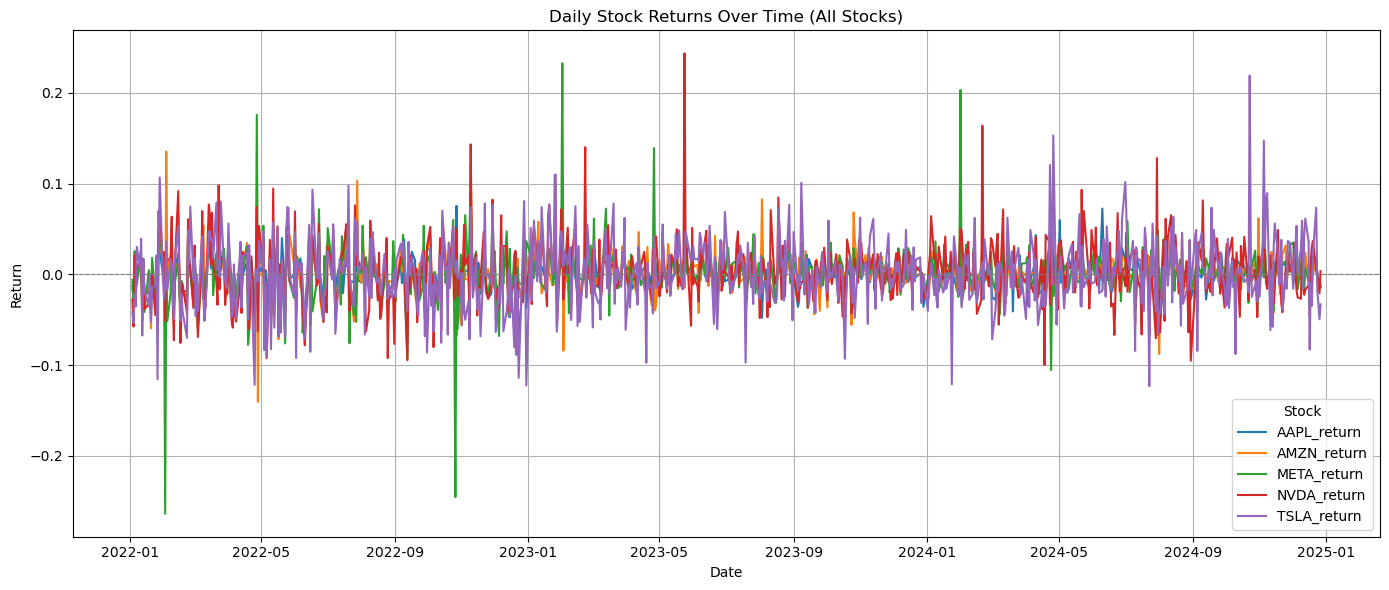

In [86]:
plt.figure(figsize=(14, 6))

for col in returns.columns:
    plt.plot(returns.index, returns[col], label=col)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Daily Stock Returns Over Time (All Stocks)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(title="Stock")
plt.grid(True)
plt.tight_layout()
plt.show()


In [129]:
import pandas as pd
import numpy as np
import yfinance as yf


reddit = pd.read_csv('all_features.csv', parse_dates=['Date'], index_col='Date')
reddit.index = reddit.index.date
reddit = reddit.shift(1) 

tickers = ['AAPL', 'TSLA', 'META', 'AMZN', 'NVDA']
data = yf.download(tickers, start="2022-01-01", end="2024-12-31", group_by='ticker', auto_adjust=True)

returns = pd.DataFrame()
volumes = pd.DataFrame()

for ticker in tickers:
    close = data[ticker]['Close']
    volume = data[ticker]['Volume']

    returns[f"{ticker}_return"] = close.pct_change().shift(-1)


    volumes[f"{ticker}_volume"] = volume
    for lag in [1, 2, 3]:
        volumes[f"{ticker}_volume_lag_{lag}"] = volume.shift(lag)

    
    for lag in [1, 2, 3]:
        returns[f"{ticker}_return_lag_{lag}"] = close.pct_change().shift(lag)

returns.index = returns.index.date
volumes.index = volumes.index.date

features = reddit.join(returns, how='inner')
features = features.join(volumes, how='inner')

features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

X = features.drop(columns=[col for col in features.columns if col.endswith('_return') and not col.startswith(tuple(t + "_return_lag_" for t in tickers))])
y = features[[f"{ticker}_return" for ticker in tickers]]



[*********************100%***********************]  5 of 5 completed


In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

target_cols = [col for col in y.columns if col.endswith('_return')]
feature_cols = X.columns

X_clean = X.replace([np.inf, -np.inf], np.nan).dropna()
y_clean = y.loc[X_clean.index]

# 3. Split into train/test (last 60 days = test)
X_train, X_test = X_clean[:-60], X_clean[-60:]
y_train, y_test = y_clean[:-60], y_clean[-60:]

##4. Train a Random Forest model for each stock
from collections import defaultdict
results = defaultdict(dict)

for stock in target_cols:
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train[stock])
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test[stock], y_pred, squared=False)
    r2 = r2_score(y_test[stock], y_pred)

    results[stock]['RMSE'] = rmse
    results[stock]['R2'] = r2

    print(f"✅ {stock}: RMSE = {rmse:.6f}, R² = {r2:.4f}")


✅ AAPL_return: RMSE = 0.011527, R² = -0.1714
✅ TSLA_return: RMSE = 0.057935, R² = -0.3702
✅ META_return: RMSE = 0.020211, R² = -0.4869
✅ AMZN_return: RMSE = 0.019369, R² = -0.0676
✅ NVDA_return: RMSE = 0.025309, R² = -0.2331
